In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show, rc
%matplotlib inline
import pandas as pd
import glob
import itertools
from numpy import inf
import sys

sys.path.insert(0, "/Volumes/Samsung_T5/Guppies/analysis/utils/")
# sys.path.insert(0, "/media/angela/Samsung_T5/Guppies/analysis/utils/")


from IndividualProperties import *
from utils_kinematics import *
from preprocessing import *
from katz import *
from prepare_data import *
import itertools
import seaborn as sns
from scipy.stats.mstats import mquantiles
from imp import reload 
import scipy
import numpy.matlib
import pickle
import json

import configparser
from warnings import filterwarnings
filterwarnings('ignore')

### Load and read json config files

In [2]:
config_file = '/Volumes/Samsung_T5/Guppies/analysis/config.json'
json_path = '/Volumes/Samsung_T5/Guppies/data_info/info_control_trials.json'


In [3]:
with open(config_file, "r") as config_info:
    config = json.load(config_info)

In [4]:
with open(json_path, "r") as info_data:
    info_data_ = json.load(info_data)

## Define default values
Here I define those values that never change (e.g. numfish, framerate,etc)

In [5]:
config

{'Config_file': {'num_fish': 8,
  'window': 170,
  'fs_par': 34,
  'fs_ctr': 30,
  'step_derivative': 8}}

In [6]:
npz_path = '/Volumes/Samsung_T5/Guppies/data/control/'
numfish = config['Config_file']['num_fish']
window = config['Config_file']['window']
fs_par = config['Config_file']['fs_par']
fs_ctr = config['Config_file']['fs_ctr']
step_derivative = config['Config_file']['step_derivative']

In [7]:
## Not to repeate this all the time
sbt = info_data_['Control_trials']

fs = fs_ctr

## Dataframe - withouth and with rolling window
Here I load all individual npz files, calculate speed, acceleration, heading, normalized speed and nearest neighbour distance

The second part is done withina rolling window of the size that is defined in the config file

In [ ]:
# npz_path + filename

In [9]:
# '/Volumes/Samsung_T5/Guppies/output_data/parasite/window_'+str(window)+'frames/'

In [10]:
for trial in list(sbt.keys()):
    
    #### Define here properties of trial
    filename = sbt[trial]['filename']
    parasite_load = sbt[trial]['parasite_load']
    trialname = sbt[trial]['trialname']
    day = sbt[trial]['day']
    tracks = glob.glob(npz_path+filename+'/*.npz')
    ### Load x,y coordinates
    mapped_data = load_data_group_analysis(tracks)
    
    
    '''Determine here what was the netID assigned from the tracker, swap position from whichever ID it was to always have the focal fish with ID 0'''

    ff_ = np.int(sbt[trial]['id_focalfish']) 
    
    pos1, pos2h = 0, ff_  ### Move ff to position 0
    mapped_data_ = swapPositions(mapped_data,pos1,pos2h)
    min_frame = np.int(sbt[trial]['min_frame']) 
    max_frame = np.int(sbt[trial]['max_frame']) 
    total_frames = max_frame-min_frame
    
    ##################################################
    ############## Create dataframe ##################
    ##################################################
    
    ### Initialize empty dataframe
    df_ = []
    for fish in range(numfish):
        df_tmp_ = pd.DataFrame(mapped_data_[fish])
        df_tmp_.insert(loc=0, column='FishID', value=fish)
        value = df_tmp_['frame'][0]
        
        ### Fill in dataframe with nans where the first frame is not there
        if value > 0:
            
            df_tmp__ = df_tmp_.shift(periods=np.int(value))
            df_tmp__[0:int(value)] = np.nan
            df_tmp__['FishID'][0:int(value)] = fish
            df_tmp__['frame'][0:int(value)] = range(int(value))
        else:
            df_tmp__ = df_tmp_[df_tmp_['FishID']==fish]
            
        df_.append(df_tmp__[min_frame:max_frame])
    df_ = pd.concat(df_,axis = 0)
    
    df_[df_ == inf] = np.nan 
    
    ####### Interpolate 

    grouped_ = df_.groupby('FishID')
    tmp_=[]
    df_speed = []
    for fish in range(numfish):
        tmp = grouped_.get_group(fish)
        tmp = tmp.interpolate(methods='linear')
#         tmp_.append(tmp)
#     df_ = pd.concat(tmp_)
    
    ##################################################
    ############# Speed and acceleration #############
    ##################################################

    
    #grouped_fish = df_.groupby('FishID')
    #for fish in range(numfish):
        df_tmp_fish = tmp #_grouped_fish.get_group(fish)
    #     print(df_tmp_fish.head())
        df_tmp_fish['SPEED_tmp'],df_tmp_fish['ACCELERATION_tmp'],df_tmp_fish['HEADING'] = get_speed_acceleration_heading(df_tmp_fish['X#wcentroid'].values,df_tmp_fish['Y#wcentroid'].values, fps = fs,stepsize=step_derivative)
        
        df_speed.append(df_tmp_fish)
    df_ = pd.concat(df_speed,axis = 0)
    
    
#     df_tmp_h = df_

    #### SPEED
    max_speed_h = np.nanpercentile(df_['SPEED_tmp'],99.9)
    print(max_speed_h)
    
    df_['SPEED']= np.zeros((total_frames*numfish))
    df_['SPEED'] = df_['SPEED_tmp'].values
    df_['SPEED'].loc[df_['SPEED'].values > max_speed_h] = np.nan


    #### ACCELERATION
    max_accel_h = np.nanpercentile(np.abs(df_['ACCELERATION_tmp']),99.9)
    print(max_accel_h)

    df_['ACCELERATION']= np.zeros((total_frames*numfish))
    df_['ACCELERATION'] = df_['ACCELERATION_tmp'].values
    df_['ACCELERATION'].loc[np.abs(df_['ACCELERATION'].values) > max_accel_h] = np.nan
    
    
#     df_ = df_tmp_h

    df_ = df_.drop(columns = ['SPEED_tmp', 'ACCELERATION_tmp'])
    
    #### NORMALIZED SPEED

    df_ = normalize_speed(df_,total_frames)
    
    ### NEAREST NEIGHBOUR DISTANCE
    
    df_ = get_nearest_neighbour_dist(df_,total_frames)
    
    df_.insert(loc=2, column='Day', value=day)
    
    if day != '01':
        df_.insert(loc=3, column='Group_state', value='Sick')
    else:
        df_.insert(loc=3, column='Group_state', value='Healthy')
        
    df_.insert(loc=4, column='Trial', value=trial)
    df_.insert(loc=5, column='Parasite_load', value=parasite_load)
    df_.insert(loc=6, column='Focal_fish',value = np.nan)
    ff=0 ### This is the focal fish after swapping positions
    df_['Focal_fish'][df_['FishID']!=ff] = 'No'
    df_['Focal_fish'][df_['FishID']==ff] = 'Yes'
    print(df_.head())
#     break
#     df_.to_pickle('/media/angela/Samsung_T5/Guppies/deep_learning_jacob/'+str(filename)+'_'+str(window)+'_input'+'.pkl')
    df_ = df_.reset_index(drop=True)
#     df_.to_pickle('/media/angela/Samsung_T5/Guppies/deep_learning_jacob/control/'+str(filename)+'_input'+'.pkl')
    df_.to_pickle('/Volumes/Samsung_T5/Guppies/output_data/control/input/'+ str(filename)+'_input.pkl')
    
    
    
    ############################################################################################################################################################################################################    
    ###########################################################################################ROLLING WINDOW ##################################################################################################
    ############################################################################################################################################################################################################
    dfw_ = []   ###will be df after rolling window
    df_gbf = df_.groupby('FishID')  ###df grouped by fish
    start_frame = min_frame + window//2
    end_frame = max_frame - window//2 + 1
    for fish in range(numfish):
        tmpw_ = pd.DataFrame()
        dfw = df_gbf.get_group(fish)

    
        tmpw_['X#wcentroid'] = np.nanmean(rolling_window(dfw['X#wcentroid'].values, window),-1)
        tmpw_['Y#wcentroid'] = np.nanmean(rolling_window(dfw['Y#wcentroid'].values, window),-1)
    
#         tmpw_['X#wcentroid1'] = pd.Series(dfw['X#wcentroid'].values).rolling(window=window*fs).mean().values 
#         tmpw_['Y#wcentroid1'] = pd.Series(dfw['Y#wcentroid'].values).rolling(window=window*fs).mean().values 
        
        tmpw_['BORDER_DISTANCE#pcentroid'] = np.nanmean(rolling_window(dfw['BORDER_DISTANCE#pcentroid'].values, window),-1)
        tmpw_['FishID'] = fish
        tmpw_['frame'] = np.arange(start_frame,end_frame)

        dfw_.append(tmpw_)
    dfw_ = pd.concat(dfw_,axis = 0)
    dfw_ = dfw_[['FishID','frame','X#wcentroid','Y#wcentroid','BORDER_DISTANCE#pcentroid']]
    
    
    
    
    ################
    ####ADD INFO####
    ################
    
   
    total_frames_w = total_frames - (window) +1
    
    dfw_speed = []
    grouped_fish = dfw_.groupby('FishID')
    for fish in range(numfish):
        dfw_tmp_fish = grouped_fish.get_group(fish)
    #     print(df_tmp_fish.head())
        dfw_tmp_fish['SPEED_tmp'],dfw_tmp_fish['ACCELERATION_tmp'],dfw_tmp_fish['HEADING'] = get_speed_acceleration_heading(dfw_tmp_fish['X#wcentroid'].values,dfw_tmp_fish['Y#wcentroid'].values, fps = fs,stepsize=step_derivative)
        
        dfw_speed.append(dfw_tmp_fish)
    dfw_ = pd.concat(dfw_speed,axis = 0)
    
    
    dfw_tmp_h = dfw_

    #### SPEED
    max_speed_hw = np.nanpercentile(dfw_tmp_h['SPEED_tmp'].values,99.9)
    print(max_speed_hw)
    
    dfw_tmp_h['SPEED']= np.zeros((total_frames_w*numfish))
    dfw_tmp_h['SPEED'] = dfw_tmp_h['SPEED_tmp'].values
    dfw_tmp_h['SPEED'].loc[dfw_tmp_h['SPEED'].values > max_speed_h] = np.nan


    #### ACCELERATION
    max_accel_hw = np.nanpercentile(np.abs(dfw_tmp_h['ACCELERATION_tmp'].values),99.9)
    print(max_accel_hw)
    
    
    dfw_tmp_h['ACCELERATION']= np.zeros((total_frames_w*numfish))
    dfw_tmp_h['ACCELERATION'] = dfw_tmp_h['ACCELERATION_tmp'].values
    dfw_tmp_h['ACCELERATION'].loc[np.abs(dfw_tmp_h['ACCELERATION'].values) > max_accel_h] = np.nan
    
    
    dfw_ = dfw_tmp_h

    dfw_ = dfw_.drop(columns = ['SPEED_tmp', 'ACCELERATION_tmp'])
    
    #### NORMALIZED SPEED

    dfw_ = normalize_speed(dfw_,total_frames_w)
    
    ### NEAREST NEIGHBOUR DISTANCE
    
    dfw_ = get_nearest_neighbour_dist(dfw_,total_frames_w)
    
    dfw_.insert(loc=2, column='Day', value=day)
    
    if day != '01':
        dfw_.insert(loc=3, column='Group_state', value='Sick')
    else:
        dfw_.insert(loc=3, column='Group_state', value='Healthy')
        
    dfw_.insert(loc=4, column='Trial', value=trial)
    dfw_.insert(loc=5, column='Parasite_load', value=parasite_load)
    dfw_.insert(loc=6, column='Focal_fish',value = np.nan)
    
    dfw_['Focal_fish'][dfw_['FishID']!=ff] = 'No'
    dfw_['Focal_fish'][dfw_['FishID']==ff] = 'Yes'
    print(dfw_.head())
    dfw_ = dfw_.reset_index(drop=True)
    dfw_.to_pickle('/Volumes/Samsung_T5/Guppies/output_data/control/window_'+str(window)+'frames/input/'+ str(filename)+'_input.pkl')
    
    

17.023837101949045
36.124710872337616
       FishID    frame Day Group_state  Trial Parasite_load Focal_fish  \
20000     0.0  20000.0  01     Healthy  t1c_h             0        Yes   
20001     0.0  20001.0  01     Healthy  t1c_h             0        Yes   
20002     0.0  20002.0  01     Healthy  t1c_h             0        Yes   
20003     0.0  20003.0  01     Healthy  t1c_h             0        Yes   
20004     0.0  20004.0  01     Healthy  t1c_h             0        Yes   

             time  X#wcentroid  Y#wcentroid  BORDER_DISTANCE#pcentroid  \
20000  576.701660    10.515686    67.257782                  10.520395   
20001  576.732056    10.577968    66.845039                  10.549766   
20002  576.762329    10.632938    66.444695                  10.600504   
20003  576.788452    10.670397    66.091980                  10.663436   
20004  576.817871    10.706733    65.768227                  10.703417   

        HEADING     SPEED  ACCELERATION  norm_speed   nn_dist  
20000   

In [13]:
# mapped_data

# Pairwise

In [14]:
# input_path

In [15]:
input_path = '/Volumes/Samsung_T5/Guppies/output_data/control/'
for trial in list(sbt.keys()):
    
    #### Define here properties of trial
    filename = sbt[trial]['filename']
    trialname = sbt[trial]['trialname']
    day = sbt[trial]['day']
    tracks = glob.glob(input_path+'window_'+str(window)+'frames/input/'+str(filename)+'_input.pkl')

    ### Load x,y coordinates
    df_ = pd.read_pickle(tracks[0])
    quantities = 4
    
    min_frame = np.int(sbt[trial]['min_frame']) 
    max_frame = np.int(sbt[trial]['max_frame']) 
    total_frames = max_frame-min_frame
    total_frames_w = total_frames - (window) +1
    init_df = np.zeros((total_frames_w,quantities,numfish,numfish-1))
    ##### call pairwise function #####
    pairwise_df = pairwise_metrices(df_,init_df,numfish=8,tot_frames = total_frames_w)
    np.savez(input_path+'window_'+str(window) + 'frames/pairwise/' +str(filename)+'_pairwise',pairwise_df)



# Output

In [16]:
input_path = '/Volumes/Samsung_T5/Guppies/output_data/control/'
for trial in list(sbt.keys()):
    filename = sbt[trial]['filename']

    tracks = glob.glob(input_path+'window_'+str(window)+'frames/input/'+str(filename)+'_input.pkl')

    df_ = pd.read_pickle(tracks[0])

    df_output_ = []
    
    shifts = [15,30,45]
    value = 0
    grouped_ = df_.groupby('FishID')

    for fish in range(numfish):

        df_tmp = grouped_.get_group(fish)
        df_tmp = df_tmp.drop(['X#wcentroid','Y#wcentroid','BORDER_DISTANCE#pcentroid','SPEED','ACCELERATION','norm_speed','nn_dist'],axis =1)

        ff_psi = df_tmp['HEADING'].values 
        
        for shift in shifts:

            ############## Heading variation  ############

            ff_psi = np.array(ff_psi)
            dff_psi = ff_psi[shift:]-ff_psi[0:-shift]
            dff_psi = np.arctan2(np.sin(dff_psi),np.cos(dff_psi))

            nans = np.tile(np.nan,shift)
            dff_psi_ = np.append(dff_psi,nans)   


            df_tmp['delta_angle_'+str(shift)+'frames'] = dff_psi_

        df_output_.append(df_tmp)

    df_output_ = pd.concat(df_output_,axis = 0)

    df_output_.to_pickle(input_path+'window_' + str(window)+'frames/output/' +str(filename)+'_output.pkl')




# Find subgroups

In [17]:
data_path = '/Volumes/Samsung_T5/Guppies/output_data/control/'
data_path_group = '/Volumes/Samsung_T5/Guppies/output_data/control/'+'window_' + str(window)+'frames/groupmembership/'

for trial in list(sbt.keys()):
    filename = sbt[trial]['filename']
    pairwise_= glob.glob(data_path+'window_' + str(window)+'frames/pairwise/'+str(filename)+'_pairwise.npz')
#     pairwise_ = glob.glob(data_path+f[0]+'_pairwise.npz')

    df_pairwise = np.load(pairwise_[0])
    df_pairwise = [df_pairwise[key] for key in df_pairwise]
    df_pw = np.squeeze(np.asarray(df_pairwise))

    
    parasite_load = sbt[trial]['parasite_load']
    
    print(filename + ',','parasite load: ' + str(parasite_load))
    trial = sbt[trial]['trialname']

    mask = np.tile(True,(numfish,numfish))
    mask[range(numfish),range(numfish)] = False

    numsteps = df_pw.shape[0]
    # Group membership - get which are in the largest group
    groupmembership = np.zeros((numsteps,numfish))
    cutoff = 30 # 90th quantile of nn distance for an example dataset

    for idx,step in enumerate(range(numsteps)):
        if idx % 100000 == 0:
#         if step == 1000:
            print(idx)
        Aij = np.zeros((numfish,numfish))
        Aij[mask] = np.reshape(np.heaviside(cutoff-df_pw[step,0],0) ,-1)
    #         Aij[range(numfish),range(numfish)] = 0  
        groupmembership[step] = getcomponents(Aij,numfish= numfish)[0]
    outfile = data_path_group+filename+'-groupmembership.pkl'
    pickle.dump([groupmembership,cutoff],open(outfile,'wb'))

guppy_8_t20_d1, parasite load: 0
0
100000
200000
300000
guppy_8_t20_d5_control, parasite load: 0
0
100000
200000
300000
guppy_8_t21_d1, parasite load: 0
0
100000
200000
300000
guppy_8_t21_d5_control, parasite load: 0
0
100000
200000
300000
guppy_8_t3_control, parasite load: 0
0
100000
200000
300000
guppy_8_t3_d3_control, parasite load: 0
0
100000
200000
300000
guppy_8_t4_control, parasite load: 0
0
100000
200000
300000
guppy_8_t4_d9_control, parasite load: 0
0
100000
200000
300000
guppy_8_t5_control, parasite load: 0
0
100000
200000
300000
guppy_8_t5_d9_control, parasite load: 0
0
100000
200000
300000
guppy_8_t6_d1_control, parasite load: 0
0
100000
200000
300000
guppy_8_t6_d7_control, parasite load: 0
0
100000
200000
300000


## Plots

In [18]:
input_path = '/Volumes/Samsung_T5/Guppies/output_data/control/'

tracks_nw = glob.glob(input_path+'input/guppy_8_t21_d5_control_input.pkl')
tracks_w = glob.glob(input_path+'window_'+str(window)+'frames/input/guppy_8_t21_d5_control_input.pkl')

### Load x,y coordinates
df_ = pd.read_pickle(tracks_nw[0])
dfw_ = pd.read_pickle(tracks_w[0])
                   

In [19]:
font = {'size': 23,
        }
labelsize = 23
xylabelfontsize = 23
linesize = 4


Text(0.5, 1.0, 'Tracjectories compared - rolling window of 5.00 seconds')

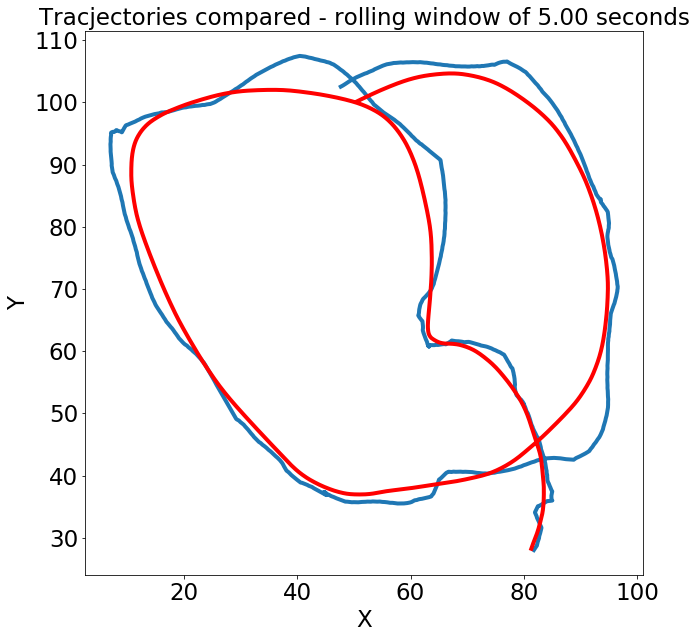

In [20]:
fig, ax  = plt.subplots(figsize=(10,10))
# plt.figure(figsize=(10,10))


shift = window/2
range_ = np.arange(7400,9200)
range_shift = np.arange(7400-shift,9200-shift)
ax.plot(df_['X#wcentroid'][range_],df_['Y#wcentroid'][range_], linewidth=linesize)
ax.plot(dfw_['X#wcentroid'][range_shift],dfw_['Y#wcentroid'][range_shift],'red', linewidth=linesize)
ax.set_xlabel('X', fontsize=xylabelfontsize)
ax.set_ylabel('Y', fontsize=xylabelfontsize)
ax.tick_params(labelsize=labelsize)
winsize = '{0:.2f}'.format(window/fs_par)
plt.title('Tracjectories compared - rolling window of '  + str(winsize) + ' seconds',fontdict=font)
# plt.savefig('/Volumes/Samsung_T5/Guppies/figures/example_traj_window'+str(window)+'.pdf',transparent=True)

In [21]:
len(range_)

1800

Text(0.5, 1.0, 'Speed compared - rolling window of 5.00 seconds')

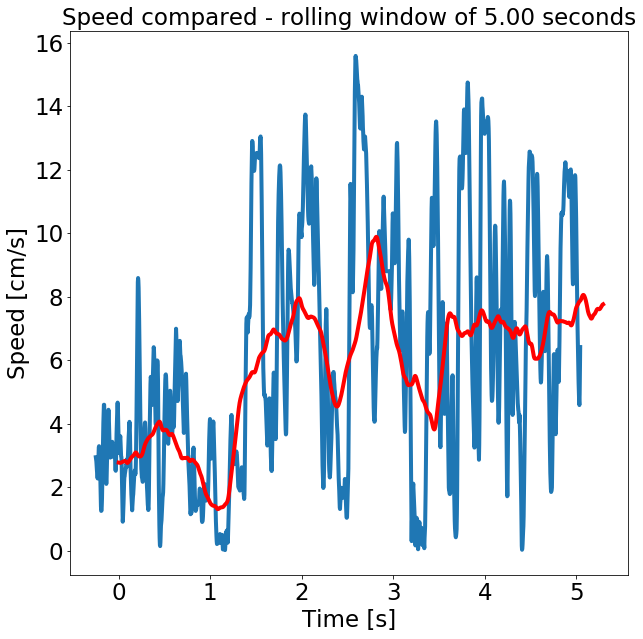

In [23]:


fig, ax  = plt.subplots(figsize=(10,10))
shift = window/2
range_ = np.arange(7400,9200)
range_shift = np.arange(7400-shift,9200-shift)
ax.plot(np.arange(-window/2,len(range_)-window/2),df_['SPEED'][range_], linewidth=linesize)
ax.plot(np.arange(0,len(range_)),dfw_['SPEED'][range_],'r', linewidth=linesize)
ax.set_ylabel('Speed [cm/s]', fontsize=xylabelfontsize)
ax.set_xlabel('Time [s]', fontsize=xylabelfontsize)
ax.set_xticks([0,340,680,1020,1360,1700])
ax.set_xticklabels(['0','1','2','3','4','5'])
ax.tick_params(labelsize=labelsize)

plt.title('Speed compared - rolling window of '  + str(winsize) + ' seconds',fontdict=font)
# plt.savefig('/Volumes/Samsung_T5/Guppies/figures/example_speed_window'+str(window)+'.pdf',transparent=True)

In [ ]:
# plt.hist(dfw_['SPEED'])
# plt.hist(df_['SPEED'])

Text(0.5, 1.0, 'Heading compared - rolling window of 5.00 seconds')

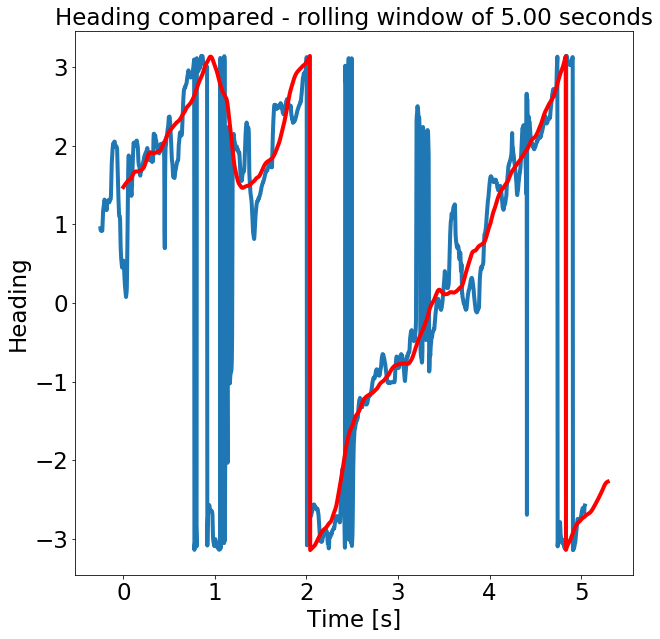

In [24]:
fig, ax  = plt.subplots(figsize=(10,10))
shift = window/2
range_ = np.arange(7400,9200)
range_shift = np.arange(7400-shift,9200-shift)
ax.plot(np.arange(-window/2,len(range_)-window/2),df_['HEADING'][range_], linewidth=linesize)
ax.plot(np.arange(0,len(range_)),dfw_['HEADING'][range_],'r', linewidth=linesize)
ax.set_ylabel('Heading', fontsize=xylabelfontsize)
ax.set_xlabel('Time [s]', fontsize=xylabelfontsize)
ax.set_xticks([0,340,680,1020,1360,1700])
ax.set_xticklabels(['0','1','2','3','4','5'])
ax.tick_params(labelsize=labelsize)
plt.title('Heading compared - rolling window of '  + str(winsize) + ' seconds',fontdict=font)
# plt.savefig('/Volumes/Samsung_T5/Guppies/figures/example_heading_window'+str(window)+'.pdf',transparent=True)

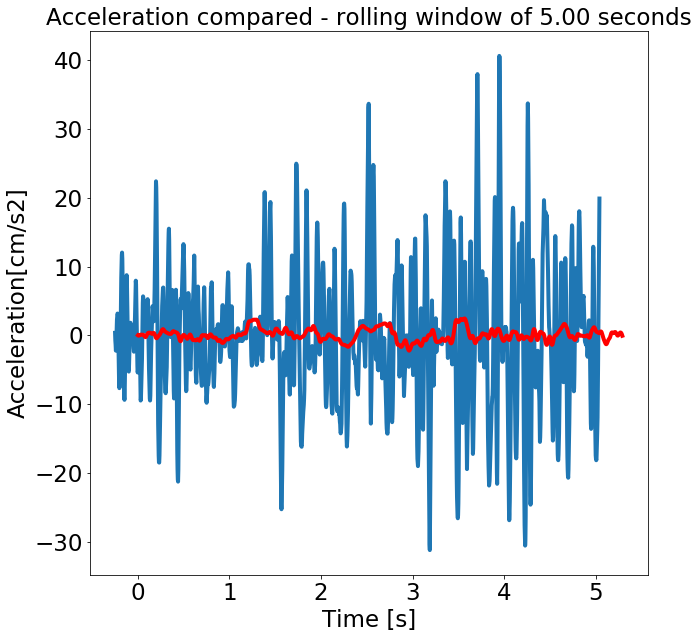

In [25]:

fig, ax  = plt.subplots(figsize=(10,10))
shift = window/2
range_ = np.arange(7400,9200)
range_shift = np.arange(7400-shift,9200-shift)
ax.plot(np.arange(-window/2,len(range_)-window/2),df_['ACCELERATION'][range_], linewidth=linesize)
ax.plot(np.arange(0,len(range_)),dfw_['ACCELERATION'][range_],'r', linewidth=linesize)

ax.set_ylabel('Acceleration[cm/s2]', fontsize=xylabelfontsize)
ax.set_xlabel('Time [s]', fontsize=xylabelfontsize)
ax.set_xticks([0,340,680,1020,1360,1700])
ax.set_xticklabels(['0','1','2','3','4','5'])
ax.tick_params(labelsize=labelsize)
plt.title('Acceleration compared - rolling window of '  + str(winsize) + ' seconds',fontdict=font)
# plt.savefig('/Volumes/Samsung_T5/Guppies/figures/example_acceleration_window'+str(window)+'.pdf',transparent=True)